# **Wildfire Detection**

The task of this demo is to detect fire or smoke in the forests/open land using images captured via a camera mounted on a drone or robot or satelites.

The dataset is available at: https://github.com/aiformankind/wildfire-dataset/tree/master/wildfire-smoke 

The dataset contains the images of fire in the scene collected from google and bing search engine. The images are grouped into two folders - positive and negative. 

The images that contain fire/smoke are placed inside the Positive folder and the images that do not contain fire are placed inside the Negative folder. 

We will create a Convolutional Neural Network and classify the images. 
You will learn how to use GPUs in this demonstration (only for those using the Google Colab). 

We will perform the following tasks in this demo:


1.   Downloading the data from the github 
2.   Data visualization using OpenCV library 
3.   Data preparation
4.   Build a convolutional neural network
5.   Image augmentation 
6.   Train the network on the training data using GPUs 
7.   Tune or optimize the hypertparameters on the test data
8.   Predict the class label for unknown samples


Remember to turn on the GPU for faster training. This can be done by

Runtime --> Change runtime type --> Hardware accelerator --> GPU

In [1]:
# import the necessary libraries
import tensorflow as tf     # import the TensorFlow library.
import numpy as np
import matplotlib.pyplot as plt
import cv2  # import the OpenCV library. OpenCV contains functions for computer vision and image processing tasks.
import os   # The OS module in python provides functions for interacting with the operating system (ex. files and folders).



Instead of manually downloading the dataset and then uploading it to the drive, we can just use the command "!git clone https://github.com/aiformankind/wildfire-dataset.git " to download the repository (GitHub folder) in Colab itself.

#Download the dataset

In [2]:
!git clone https://github.com/aiformankind/wildfire-dataset.git

fatal: destination path 'wildfire-dataset' already exists and is not an empty directory.


# Dataset Description

The folder which contains the images is divided in this order \\
-> wildfire-dataset \\
---> wildfire-smoke \\
-----> bing/google \\
-------> positive/negative \\

The positive images contain fire or smoke. The negative images do not have fire or smoke. 

# Data Visualization

All tasks related to images (loading the image, resizing, converting to different color formats(RGB,grayscale), performing image processing tasks etc. ) is done using the OpenCV library.

* The library can be called by using the command " import cv2 
".

* To read an image, we use the command " cv2.imread(image path) ". The image is stored as a 3-dimensional numpy array if it is a colored image or 2-dimensional numpy array if it is a grayscale image.

* To resize an image, we use the command "cv2.resize(image,new_size)".

* To display an image, we use the matplotlib command " plt.imshow() ".

* The imread function stores the image in the form BGR (blue,green,red). However in order to display it correctly using the matplotlib library, we need to convert the BGR format to RGB format. This is achieved using the cv2.cvtColor(image, cv2.COLOR_BGR2RGB) function.

(-0.5, 614.5, 409.5, -0.5)

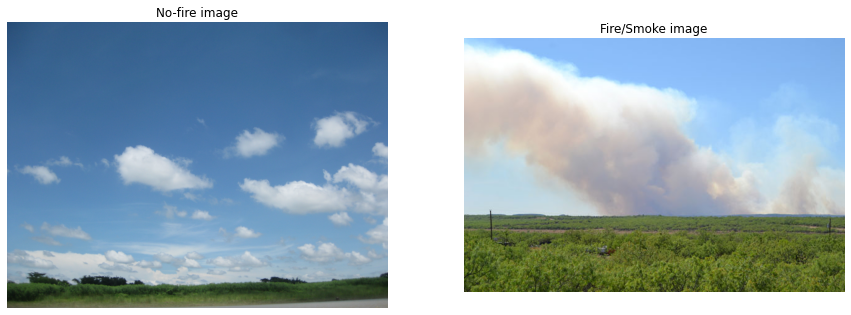

In [3]:
# Examples to show you how to use OpenCV to visualize images. Just one image is taken for this purpose. 
img1 = cv2.imread('/content/wildfire-dataset/wildfire-smoke/bing/negative/00000000.jpg') # read the image
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)  # convert from BGR to RGB
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(img1)  #display the image
plt.title("No-fire image")
plt.axis('off')   # turn off the axis display

img2 = cv2.imread('/content/wildfire-dataset/wildfire-smoke/bing/positive/00000000.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.title("Fire/Smoke image")
plt.axis('off')

In [4]:
# print the shape of the images. This can be done by using the .shape function.
print('shape of No-fire image: ',img1.shape)
print('shape of Fire/Smoke image: ',img2.shape)

shape of No-fire image:  (2448, 3264, 3)
shape of Fire/Smoke image:  (410, 615, 3)


As we can see, the images are not of the same size. Hence while loading all the images, we will resize them to the same size. This is important as the Convolutional Neural Network expects all the inputs to be of the same size.

#Data Loading 

Each image is a separate file. Instead of manually loading every image, we will make use of python to automate the data loading. 

In order to interact with files and folders we will use the " os " library. 

The folders are called as 'directories'. All the contents inside a directory (files or folders) are called as files of that directory.

The functions that are used in this notebook are listed below:


*   os.listdir(directory path) - list all the contents inside a directory. 
*   os.path.isdir(path) - check if the path refers to a directory or a file. 



In [5]:
image_directory = '/content/wildfire-dataset/wildfire-smoke/'   # Specify the path of the main directory
filenames = os.listdir(image_directory)   #get a list of folders in the main directory
print(filenames)    # print names of all the folders in the main directory

['bing', 'google', '.DS_Store']


In [6]:
samples = []
labels = []

# list all the image directories
directory = ['/content/wildfire-dataset/wildfire-smoke/bing/positive','/content/wildfire-dataset/wildfire-smoke/bing/negative','/content/wildfire-dataset/wildfire-smoke/google/positive']

# loop through each directory and read the images one at a time
for dir in directory:
  print(dir)
  if dir=='/content/wildfire-dataset/wildfire-smoke/bing/positive' or dir == '/content/wildfire-dataset/wildfire-smoke/google/positive' :
    label = 1   # assign label = 1 if directory is positive
  else:
    label = 0   # assign label = 0 if directory is negative
  images = os.listdir(dir)         # list all the image names inside the directory
  for image_name in images:
    image_path = dir + '/' + image_name
    img = cv2.imread(image_path)                   # read each image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # convert from BGR to RGB
    img = cv2.resize(img, (128, 128))               # resize image to (128,128,3)
    img = img / 255.0                               # Normalize images to range [0,1]. So, normalize with respect to the maximum value of the pixel (i.e., 255). 
    samples.append(img)                             # append the image to a list "samples"
    labels.append(label)                            # append the label to a list "labels"
samples = np.array(samples)
labels = np.array(labels)

/content/wildfire-dataset/wildfire-smoke/bing/positive
/content/wildfire-dataset/wildfire-smoke/bing/negative
/content/wildfire-dataset/wildfire-smoke/google/positive


The steps to automate the data loading are given below:

1.   Get the list of all the files inside the main directory ('Bing','google','.DS_Store')
2.   Check if the files are directories or not. ('bing' and 'google' are directories whereas '.DS_Store' is a not a directory.
3. IF file = directory
    1. get the list of files inside the directory ('positive','negative')
    2. For each directory ('positive'/'negative'):
      1. list the files inside each directory (images)
      2. loop through the list to load one image at a time.
      3. resize the image to (512,512,3)
      4. if directory = 'positive', set the label = 1, if directory = 
         'negative', set the label = 0.
      5. Store the image with its label  

   ELSE  

    >Go to the next element in the list 


In [7]:
'''
# Generally the images will be stored in multiple directories and listing all the directories is not feasible
# In order to automate the entire dataloading process, uncomment the cell


dataset=[]    # define an empty list to store all the images and labels

image_directory = '/content/wildfire-dataset/wildfire-smoke'   # get the path of the main directory
filenames = os.listdir(image_directory)   #get the list of all the contents inside the directory

for filename in filenames:    # loop through the list
  folder = image_directory+ '/' +filename     # Concatenate strings image_directory and filename to get path of next directory
  #for example if your filename is "bing", you will get the path for the bing folder as: '/content/wildfire-dataset/wildfire-smoke/bing' etc.
  
  if os.path.isdir(folder):   #check if the new path refers to a directory or not
    print('Yes, ' + filename + ' is a directory')
    files = os.listdir(folder)  #list the contents inside the directory (positive/negative)
    print(files)

    for file in files:  # loop through the list
      img_folder = folder+ '/' + file   # Concatenate the strings folder and file to get path of the next directory
      # img_folder variable will be /content/wildfire-dataset/wildfire-smoke/bing/positive etc.

      if file =='positive':   # check if the filename is positive
        label = 1             # assign label as 1
        img_loc =os.listdir(img_folder)   # list all the contents of the file (images)
        for i in img_loc:    # loop through the list
          img_address = img_folder + '/' + i  
          # img_address variable will be /content/wildfire-dataset/wildfire-smoke/bing/positive/00000000.jpg etc.
          img = cv2.imread(img_address)                   # read each image
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # convert from BGR to RGB
          img = cv2.resize(img, (512, 512))               # resize image to (512,512,3)
          img = img / 255.0                               # Normalize images to range [0,1]. So, normalize with respect to the maximum value of the pixel (i.e., 255). 
          img = [img,label]                               # store the image and label together
          dataset.append(img)                             # append the image to a list "dataset"


      if file =='negative':
        label = 0
        img_loc =os.listdir(img_folder)
        for j in img_loc: 
          img_address = img_folder + '/' + j
          img = cv2.imread(img_address) # read the image in the negative folder.  
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          img = cv2.resize(img, (512, 512))
          img = img / 255.0 # Normalize images to range [0,1]
          #plt.imshow(img)
          img = [img,label]
          dataset.append(img)
          
  else:   # print element is not a directory
    print('No,' + filename + ' is not a directory')

dataset = np.asarray(dataset)   # convert the list "dataset" into numpy array.
'''

'\n# Generally the images will be stored in multiple directories and listing all the directories is not feasible\n# In order to automate the entire dataloading process, uncomment the cell\n\n\ndataset=[]    # define an empty list to store all the images and labels\n\nimage_directory = \'/content/wildfire-dataset/wildfire-smoke\'   # get the path of the main directory\nfilenames = os.listdir(image_directory)   #get the list of all the contents inside the directory\n\nfor filename in filenames:    # loop through the list\n  folder = image_directory+ \'/\' +filename     # Concatenate strings image_directory and filename to get path of next directory\n  #for example if your filename is "bing", you will get the path for the bing folder as: \'/content/wildfire-dataset/wildfire-smoke/bing\' etc.\n  \n  if os.path.isdir(folder):   #check if the new path refers to a directory or not\n    print(\'Yes, \' + filename + \' is a directory\')\n    files = os.listdir(folder)  #list the contents inside

In [8]:
print('length of dataset: ',len(samples))

length of dataset:  343


In [9]:
labels.shape

(343,)

# Data Preparation

Split the dataset into 80% train and 20% test set

In [10]:
from sklearn.model_selection import train_test_split #import the train_test_split function from sklearn
train_X,test_X,train_y,test_y = train_test_split(samples,labels, test_size=0.20,shuffle=True,random_state=48) #split the data

print("length of training dataset: ",len(train_X))
print("length of testing dataset: ",len(test_X))

length of training dataset:  274
length of testing dataset:  69


Display first 6 images and labels from the training dataset

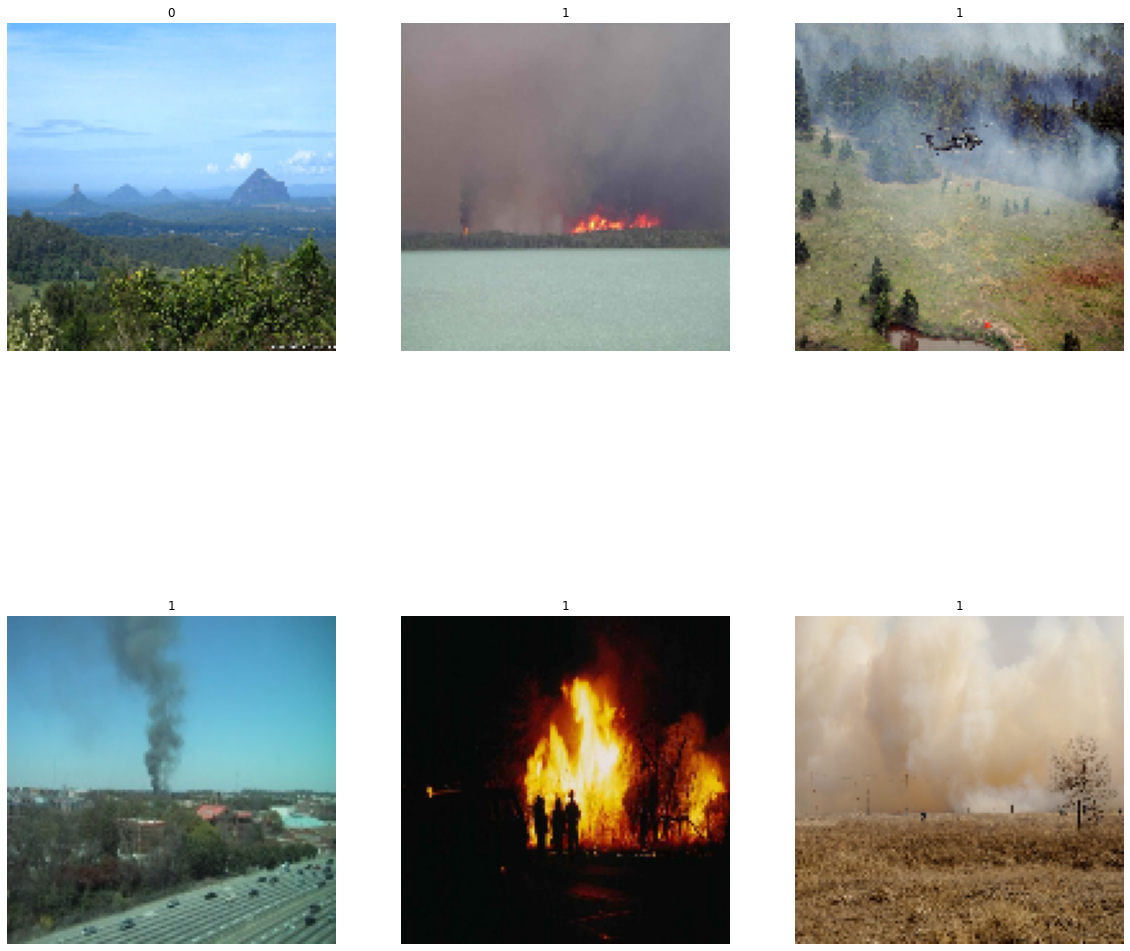

In [11]:
plt.figure(figsize=(20,20))
for i in range(6):
  img = train_X[i]
  label = train_y[i]
  plt.subplot(2,3,i+1)
  plt.imshow(img)
  plt.title(label)
  plt.axis('off')

Separate samples and labels in the trainig and testing datasets. 
The dataset is a list of the form [image,label]. So we separte image and label and store them in a separate list. 

In [12]:
print("shape of train_X: ",train_X.shape)
print("shape of train_y: ",train_y.shape)
print("shape of test_X: ",test_X.shape)
print("shape of test_y: ",test_y.shape)

shape of train_X:  (274, 128, 128, 3)
shape of train_y:  (274,)
shape of test_X:  (69, 128, 128, 3)
shape of test_y:  (69,)


The training samples dataset 'train_X' is a 4D tensor with dimensions = (number of samples, height, width, channels)

The training label 'train_y' is a 1D array of true labels.

Same for the test data.

#Build the Model architecture

The convolution neural network consists of the following layers:


*   Input layer
*   Convolutional layer
*   Pooling layer
*   Batch Normalization layer
*   Fully Connected layer
*   Output layer  

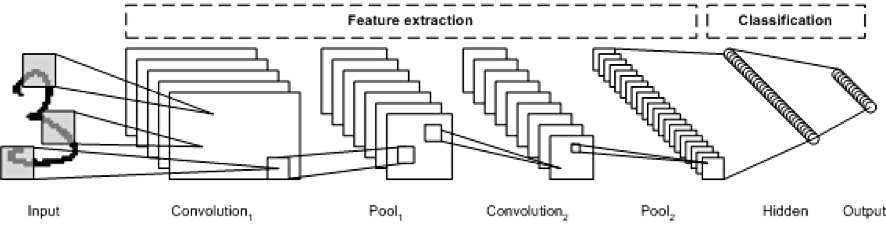

There are many arguments to each function but listed below are the ones that are used in the demo.


**Input layer** 

The shape of the input layer is the same as the input image (here 512,512,3). We do not have to explicitely define an input layer. 

**Convolutional layer**

The convolutional layer is created using the tf.keras.layers.Conv2D() function. 
The arguments of the function are:


*   filters - number of output channels ( also called as number of convolution kernels)
*   kernel_size - the size of the convolution kernel
*   strides - stride for the convolution
*   padding - add addtional rows and columns of 0 in order to keep the size of the feature map same as that of input after convolution. 
If padding = 'valid' no padding will be added. If padding = 'same' appropriate paddings will be automatically added
*   activation = activation function for that layer

**Pooling layer**

The pooling layer is created using the tf.keras.layers.MaxPool2D() or tf.keras.AvgPool2D(). The arguments are:


*   Pool_size = size of the pooling window
*   strides = strides to apply when moving the pooling window

**Batch Normalization layer**

The batch Normalization layer is created using the tf.keras.layers.BatchNormalization(). We need not provide any arguments to this function. 

**Fully Connected layer**

Before passing the input to the FCN we have to flatten it. We will use the tf.keras.layers.Flatten() to flatten the input. 

The Fully Connected layer is created using tf.keras.layers.Dense(). The arguments to the function are:
*  number of units -number of hidden neurons
*  activation - activation function

**Output layer**

The last Fully connected layer acts as the output layer. The number of units is equal to the number of classes (here 2). The activation function for the ouput layer is the softmax activation.


In [13]:
model = tf.keras.Sequential()   # build the Squential model- All the layers will be stacked sequentially

# first convolution block (Conv+pooling+batch normalization)
model.add(tf.keras.layers.Conv2D(filters = 32,kernel_size = 3,strides=(2,2),input_shape=(128,128,3),activation='relu')) #conv layer
# we can specify the input_shape if we know the shape of the input. This will help in creating the model summary and
# help visualize the model.
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))   # pooling layer with pool size =2, window size = 2x2.
model.add(tf.keras.layers.BatchNormalization())   # batch normalization to a standard Gassian distribution ( mean =0, standard distribution = 1) before loading it to the next convolutional block.
# This is to desensitize the results with random initialization of the weights with different scales.  

# second convolution block
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())


# third convolution block
model.add(tf.keras.layers.Conv2D(64,3,activation='relu'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.BatchNormalization())

# Flatten 
model.add(tf.keras.layers.Flatten())

# First FCN layer
model.add(tf.keras.layers.Dense(units=100, activation='relu'))  

#model.add(tf.keras.layers.Dropout(rate =0.2)) 

# Output layer
model.add(tf.keras.layers.Dense(2,activation='softmax'))


#get the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 63, 63, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        1

We can also plot the model. This is very useful when the model has many layers interconnected ( as in ResNet architecture).

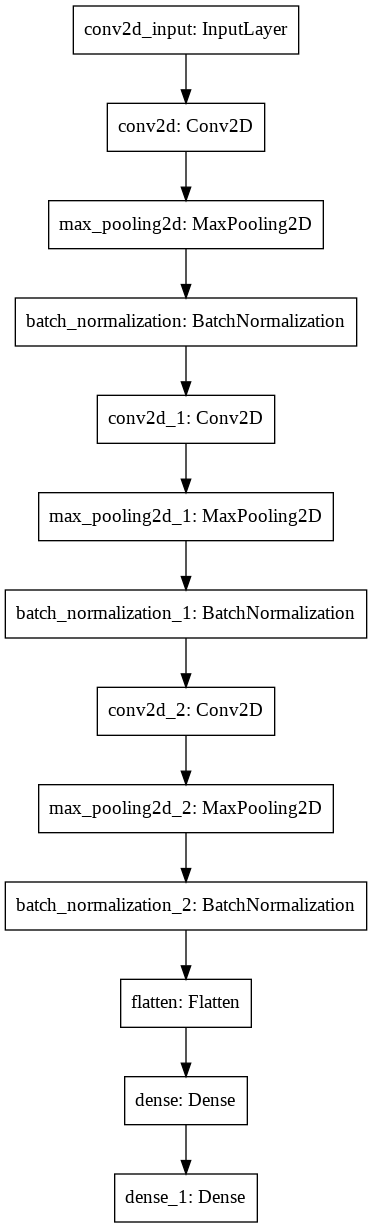

In [14]:
tf.keras.utils.plot_model(model)

# Define optimization hyperparameters ( also known as configure the model)

**compile()**:compile() is used to configure the model for the training. That is set the optimization hyperparameters. The arguments are listed below: \\
  1. optimizer: The optimization function (SGD, RMSProp, ADAM ,etc.) 
  2. loss: The loss function (MSE, MAE, Cross-entropy) \\
  3. metrics: List of metrics to be evaluated by the model during training and testing (accuracy, loss, etc.).  

In [15]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
              metrics=["accuracy"])

# Train the model

**fit()**:The fit() function starts the training of the model. The arguments are:  \\
  1. x - The input data
  2. y - Output data
  3. batch_size - Batch size for mini-batch gradient descent
  4. epoch - specify the number of times to run the training loop.
  5. validation_data - the data to validate the model on (Since our dataset is very small we will use the test data as the validation data)

Since we have very less images as our training samples, we will make use of **Image Augmentation** to increase the sample size.

This is done by using the command " tf.keras.image.ImageDataGenerator(). The different augmentations that can be performed are listed below (not limited to these). For each augmentation, we provide a range value.


*   rotation
*   zoom
*   shifting
*   shear
*   horizontal/vertical flip
*   brightness etc.

For every image, the model will randomly select a value from the range speicified for that augmentation to be applied. For example, if the range of rotation specified is 15 degrees, the model will randomly apply any angle of rotation from 0 to 15 degrees.



In [16]:
# create an instance of ImageDataGenerator- This is the instance that will apply augmentation on every image. 
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale= 1 / 255.0,
    rotation_range=15,    # rotate the images.  range=[-15,15] degrees
    zoom_range=0.05,      # zoom the image.    
    width_shift_range=0.1,  #shift the image hoizontally.  range:[-width_size*0.1,width_size*0.1]
    height_shift_range=0.1, #shift the image vertically.  range:[-height_size*0.1,height_size*0.1]
    shear_range=0.05,       # shear the image
    fill_mode="nearest")    # on applying augmentation, some of the pixels will not have any values.
                            # Ex. if we shear the image, the pixels around the corners will not have any value
                            # these pixel are filled by replicating the nearest pixels.

We use the train_datagen.flow() function to pass every input through the augmentation instance. The same augmentation will be applied to an entire batch.

In [17]:
batch_size = 16   # specify the batch size for mini-batch gradient descent
epochs = 20   #specify the number of epochs
results = model.fit(train_datagen.flow(train_X, train_y, batch_size=batch_size),steps_per_epoch=len(train_X)//batch_size,validation_data=(test_X,test_y),epochs=epochs)

Epoch 1/20
17/17 [==============================] - 1s 66ms/step - loss: 0.5425 - accuracy: 0.7868 - val_loss: 0.6209 - val_accuracy: 0.8696
Epoch 2/20
17/17 [==============================] - 1s 52ms/step - loss: 0.3369 - accuracy: 0.8798 - val_loss: 0.5753 - val_accuracy: 0.7391
Epoch 3/20
17/17 [==============================] - 1s 53ms/step - loss: 0.2864 - accuracy: 0.8566 - val_loss: 0.5650 - val_accuracy: 0.6812
Epoch 4/20
17/17 [==============================] - 1s 53ms/step - loss: 0.2007 - accuracy: 0.8992 - val_loss: 0.6930 - val_accuracy: 0.6812
Epoch 5/20
17/17 [==============================] - 1s 52ms/step - loss: 0.2708 - accuracy: 0.9070 - val_loss: 0.6280 - val_accuracy: 0.6812
Epoch 6/20
17/17 [==============================] - 1s 51ms/step - loss: 0.2442 - accuracy: 0.8837 - val_loss: 0.6408 - val_accuracy: 0.6812
Epoch 7/20
17/17 [==============================] - 1s 56ms/step - loss: 0.2187 - accuracy: 0.9264 - val_loss: 0.5479 - val_accuracy: 0.7246
Epoch 8/20
17

Final training loss: 0.1804530769586563
Final testing loss: 0.28855201601982117

Final training accuracy: 0.930232584476471
Final testing accuracy: 0.8695651888847351


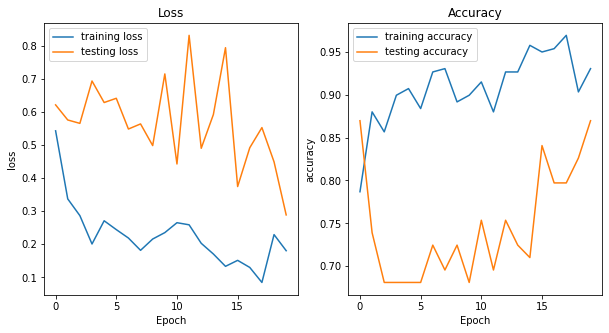

In [18]:
# plot the graph for the training and testing loss and accuracy vs number of epochs. The loss and accuracy
# values are stored inside results.history

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(results.history['loss'], label ='training loss')
plt.plot(results.history['val_loss'],label = 'testing loss')
plt.xlabel("Epoch")
plt.ylabel('loss')
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(results.history['accuracy'], label ='training accuracy')
plt.plot(results.history['val_accuracy'],label = 'testing accuracy')
plt.xlabel("Epoch")
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.legend()

print("Final training loss:",results.history['loss'][-1])
print("Final testing loss:",results.history['val_loss'][-1])
print()
print("Final training accuracy:",results.history['accuracy'][-1])
print("Final testing accuracy:",results.history['val_accuracy'][-1])

Predict the accuracy of the trained model on the test data

In [19]:
y_pred = np.argmax(model.predict(test_X), axis=1)  # get the predicted class labels
'''
model.predict will return the probability for each class. We select the class(0,1) for which
the probability is maximum by using the np.argmax() command. axis =1 means find the maximum value along the rows.
'''
#print(y_pred)
from sklearn.metrics import confusion_matrix,accuracy_score
print("Accuracy of the classifier: ",accuracy_score(y_pred,test_y))  # print the accuracy
print('confusion matrix:\n')
confusion_matrix(test_y,y_pred)   # print the confusion matrix

Accuracy of the classifier:  0.8695652173913043
confusion matrix:



array([[13,  9],
       [ 0, 47]])

# Unseen sample prediction

If output = 0 : No fire in the scene \\
If output = 1 : Fire in the scene


You can test it out for any image from the internet. Just download the image and upload the image to the Google Drive. Specify the path of the image inside cv2.imread.

(-0.5, 274.5, 182.5, -0.5)

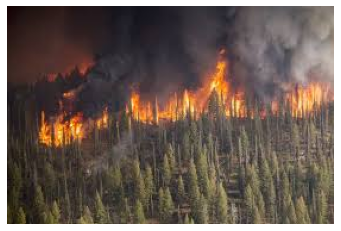

In [20]:
# load the unknown sample and display it
x_unknown = cv2.imread('/content/drive/My Drive/fire.jpg')
x_unknown = cv2.cvtColor(x_unknown,cv2.COLOR_BGR2RGB)
plt.imshow(x_unknown)
plt.axis('off')

In [21]:
# resize and normalize the image

x_unknown = cv2.resize(x_unknown,(128,128))
x_unknown = x_unknown/255.0

In [22]:
# the model expects a tensor of 4 dimension. Hence we reshape the 3D image into a 4D tensor
x_unknown = x_unknown.reshape(1, 128, 128, 3)

In [23]:
# predict the class label
model.predict_classes(x_unknown)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([1])

# Hyperparameter Tuning

The hyperparameter tuning can be performed by using:
1. Manual Search
2. Grid Search 
3. Random Search

In this demo exercise, we will use grid search method to optimise the hyperparameters. 

The hyperparameters to be optimized are:
1. Number of convolution blocks (convolution layer + pooling layer + batch normalization).
2. The number of output channels in each convolutional layer.
3. The kernel size
4. Learning Rate 

In [24]:
# grid = [number of convolutional blocks,filters, kernel size, learning rate]
grid = [[2, 64,3, 0.1 ],[1, 32,3, 0.01],[2, 32, 5, 0.01]]
accuracy_list=[]
result=[]
for hyperparams in grid:
  n_blocks = hyperparams[0]   # number of convolution blocks
  n_filters = hyperparams[1]  # number of output channels in each convolutional layer
  kernel_size = hyperparams[2]  # kernel size for convolution operation
  lr = hyperparams[3]         # learning rate

  # start building the model

  model = tf.keras.Sequential()   # build the Squential model- All the layers will be stacked sequentially

  # first convolution block (Conv+pooling+batch normalization)
  model.add(tf.keras.layers.Conv2D(filters = n_filters,kernel_size = kernel_size,strides=(2,2),input_shape=(128,128,3),activation='relu')) #conv layer
  # we can specify the input_shape if we know the shape of the input. This will help in creating the model summary and
  # help visualize the model.
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))   # pooling layer
  model.add(tf.keras.layers.BatchNormalization())   # batch normalization

  for i in range(n_blocks):
  # second convolution block
    model.add(tf.keras.layers.Conv2D(filters=n_filters,kernel_size=kernel_size,activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.BatchNormalization())

  # Flatten 
  model.add(tf.keras.layers.Flatten())

  # First FCN layer
  model.add(tf.keras.layers.Dense(units=100, activation='relu'))  # use the L2 penalty on the weights


  # Output layer
  model.add(tf.keras.layers.Dense(2,activation='softmax'))


  model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                optimizer=tf.keras.optimizers.SGD(learning_rate=lr), 
                metrics=["accuracy"])


  batch_size = 16   # specify the batch size for mini-batch gradient descent
  epochs = 20   #specify the number of epochs

  results = model.fit(
      train_datagen.flow(train_X, train_y, batch_size=batch_size),
      steps_per_epoch=len(train_X) // batch_size,
      validation_data=(test_X,test_y),
      epochs=epochs, verbose = 0
  )
  result.append(results)
  y_pred = np.argmax(model.predict(test_X), axis=1)
  accuracy_list.append(accuracy_score(y_pred,test_y))

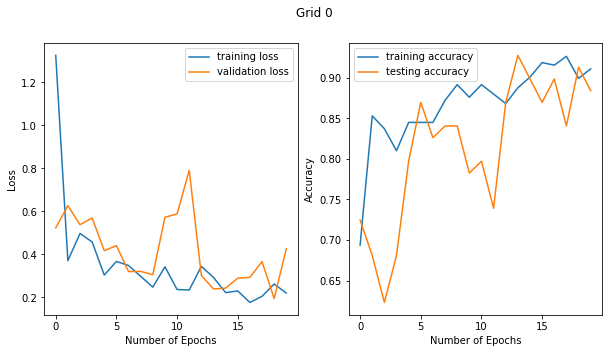

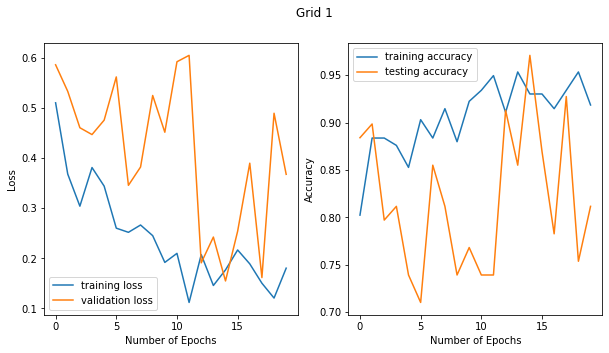

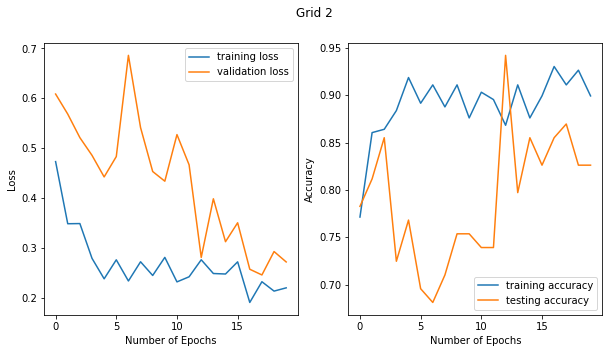

In [25]:
for i,results in enumerate(result):
  plt.figure(figsize=(10,5))
  plt.suptitle("Grid " + str(i))
  plt.subplot(1,2,1)
  plt.plot(results.history['loss'],label='training loss')
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.plot(results.history['val_loss'],label='validation loss')
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(results.history['accuracy'],label='training accuracy')
  plt.xlabel("Number of Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.plot(results.history['val_accuracy'],label='testing accuracy')
  plt.xlabel("Number of Epochs")
  plt.ylabel("Accuracy")
  plt.legend()

In [26]:
print(accuracy_list)

[0.8840579710144928, 0.8115942028985508, 0.8260869565217391]


In [27]:
print("The best grid is:\n")
print(grid[np.argmax(accuracy_list)])

The best grid is:

[2, 64, 3, 0.1]
